In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import re
import requests
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

In [2]:
products = {
    # "crypto": [
    #     "BTC-USD",
    #     "ETH-USD",
    #     "SOL-USD",
    #     "XRP-USD",
    #     "ADA-USD",
    #     "AVAX-USD",
    #     "LINK-USD",
    #     "DOT-USD",
    # ],
    # "stock": ["GBTC", "TQQQ"],
    "stock": ["GBTC", "TQQQ", "SQQQ"],
}


# def get_top_stocks(url):
#     top_stocks = []

#     with requests.Session() as req:
#         req.headers.update(
#             {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0"}
#         )

#         for ticker in ["QQQ", "VUG", "VGT"]:
#             r = req.get(url.format(ticker))
#             print(f"Extracting: {r.url}")
#             holdings = re.findall(r"etf\\\/(.*?)\\", r.text)
#             top_holdings = holdings[:30]

#             if len(top_stocks) == 0:
#                 top_stocks = top_holdings
#             else:
#                 top_stocks = list(set(top_stocks).intersection(top_holdings))

#     return top_stocks


# top_stocks = get_top_stocks("https://www.zacks.com/funds/etf/{}/holding")
# print(top_stocks)
# products["stock"] = top_stocks

In [3]:
def get_df_crypto_fear_greed_index():
    print("Retrieving historical crypto fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 5))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_etf_fear_greed_index():
    print("Retrieving historical ETF fear and greed index")
    import json

    with open("cnn_fear_greed_index_data.json") as f:
        cnn_fear_greed_index_data = json.load(f)

    df_fear_greed_index = pd.DataFrame(
        data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
    )
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id, product_type):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="5y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_fear_greed_index = df_crypto_fear_greed_index if product_type == "crypto" else df_etf_fear_greed_index
    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]], how="inner")
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        for days in [7, 14, 30, 60, 90, 120]:
            periods = get_strategy_length(days)
            df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            df_history[f"{column}_gradient_min_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            )
            df_history[f"{column}_gradient_max_{days}"] = (
                df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
            )

    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        ta=[
            {"kind": "sma", "length": get_strategy_length(10)},
            {"kind": "sma", "length": get_strategy_length(20)},
            {"kind": "sma", "length": get_strategy_length(50)},
            {"kind": "bbands", "length": get_strategy_length(20)},
            {"kind": "rsi", "length": get_strategy_length(14)},
            {
                "kind": "macd",
                "fast": get_strategy_length(8),
                "slow": get_strategy_length(21),
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(10),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(20),
                "prefix": "VOLUME",
            },
            {
                "kind": "sma",
                "close": "volume",
                "length": get_strategy_length(50),
                "prefix": "VOLUME",
            },
        ],
    )
    df_history.ta.strategy(CustomStrategy)

    return df_history


df_crypto_fear_greed_index = get_df_crypto_fear_greed_index()
df_etf_fear_greed_index = get_df_etf_fear_greed_index()

history_dfs = {}
product_ids = []

for product_type in products.keys():
    for product_id in products[product_type]:
        product_ids.append(product_id)
        history_dfs[product_id] = get_df_history(product_id, product_type=product_type)
        history_dfs[product_id]["product_id"] = product_id
        history_dfs[product_id]["product_type"] = product_type

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for product_id in product_ids:
    df_final_product = df_final.loc[df_final.product_id == product_id]
    # df_final = df_final.loc[(df_final.index >= df_final_product.index.min()) & (df_final.index <= df_final_product.index.max())]
    # df_final = df_final.loc[df_final.index.isin(df_final_product.index)]

df_final

Retrieving historical crypto fear and greed index
Retrieving historical ETF fear and greed index
Retrieving historical data for GBTC
Retrieving historical data for TQQQ
Retrieving historical data for SQQQ


,open,high,low,close,volume,dividends,stock splits,capital gains,fear_greed_index,close_previous,close_min_7,close_max_7,close_gradient_7,close_gradient_min_7,close_gradient_max_7,close_min_14,close_max_14,close_gradient_14,close_gradient_min_14,close_gradient_max_14,close_min_30,close_max_30,close_gradient_30,close_gradient_min_30,close_gradient_max_30,close_min_60,close_max_60,close_gradient_60,close_gradient_min_60,close_gradient_max_60,close_min_90,close_max_90,close_gradient_90,close_gradient_min_90,close_gradient_max_90,close_min_120,close_max_120,close_gradient_120,close_gradient_min_120,close_gradient_max_120,fear_greed_index_previous,fear_greed_index_min_7,fear_greed_index_max_7,fear_greed_index_gradient_7,fear_greed_index_gradient_min_7,fear_greed_index_gradient_max_7,fear_greed_index_min_14,fear_greed_index_max_14,fear_greed_index_gradient_14,fear_greed_index_gradient_min_14,fear_greed_index_gradient_max_14,fear_greed_index_min_30,fear_greed_index_max_30,fear_greed_index_gradient_30,fear_greed_index_gradient_min_30,fear_greed_index_gradient_max_30,fear_greed_index_min_60,fear_greed_index_max_60,fear_greed_index_gradient_60,fear_greed_index_gradient_min_60,fear_greed_index_gradient_max_60,fear_greed_index_min_90,fear_greed_index_max_90,fear_greed_index_gradient_90,fear_greed_index_gradient_min_90,fear_greed_index_gradient_max_90,fear_greed_index_min_120,fear_greed_index_max_120,fear_greed_index_gradient_120,fear_greed_index_gradient_min_120,fear_greed_index_gradient_max_120,SMA_10,SMA_20,SMA_50,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_10,VOLUME_SMA_20,VOLUME_SMA_50,product_id,product_type
2021-05-17 00:00:00+00:00,35.270000,36.250000,33.759998,35.500000,17933600,0.0,0.0,0.0,35.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBTC,stock
2021-05-17 00:00:00+00:00,46.224711,46.542626,44.865018,46.146454,69271200,0.0,0.0,0.0,35.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TQQQ,stock
2021-05-17 00:00:00+00:00,57.010752,58.610065,56.634446,57.104832,13796160,0.0,0.0,0.0,35.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SQQQ,stock
2021-05-18 00:00:00+00:00,35.020000,35.200001,34.000000,34.380001,10583200,0.0,0.0,0.0,34.8333,35.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GBTC,stock
2021-05-18 00:00:00+00:00,46.567086,47.090421,45.090009,45.178047,65842000,0.0,0.0,0.0,34.8333,46.146454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TQQQ,stock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

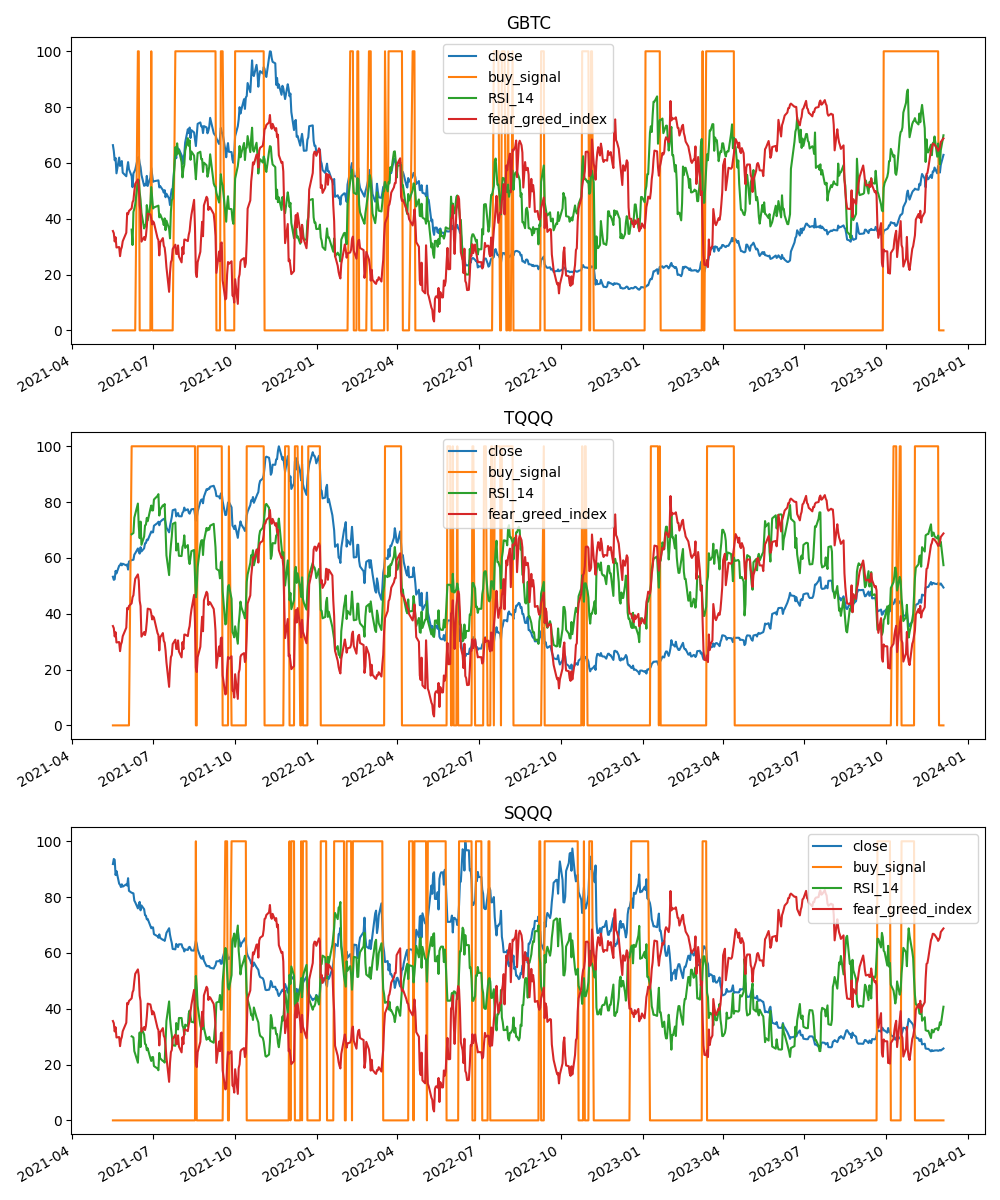

In [4]:
total_products = df_final.product_id.nunique()
fig, ax = plt.subplots(nrows=total_products, figsize=(10, 4 * total_products))
days = 14

for product_index, product_id in enumerate(df_final.product_id.unique()):
    ax_index = ax if total_products <= 1 else ax[product_index]
    df_final_product = df_final.loc[df_final.product_id == product_id]
    df_history1 = df_final_product[["close"]].copy()
    # df_history2 = df_final_product[[f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}"]].copy()
    df_history3 = df_final_product[
        [f"RSI_{days}", "fear_greed_index", f"fear_greed_index_max_{days}", f"fear_greed_index_min_{days}"]
    ].copy()
    # df_history4 = df_final_product[[f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"]].copy()
    df_history5 = df_final_product[["BBP_20_2.0"]].copy()

    df_history1_max = df_history1.to_numpy()[~np.isnan(df_history1.to_numpy())].max()
    # df_history2_max = df_history2.to_numpy()[~np.isnan(df_history2.to_numpy())].max()
    df_history3_max = df_history3.to_numpy()[~np.isnan(df_history3.to_numpy())].max()
    # df_history4_max = df_history4.to_numpy()[~np.isnan(df_history4.to_numpy())].max()
    df_history5_max = df_history5.to_numpy()[~np.isnan(df_history5.to_numpy())].max()

    for column in df_history1.columns:
        df_history1[column] = df_history1[column] / df_history1_max * 100

    df_history = (
        df_history1
        # .join(df_history2, how="outer")
        .join(df_history3, how="outer")
        # .join(df_history4, how="outer")
        .join(df_history5, how="outer")
    )
    # df_history = history_dfs[product_id]
    # row.RSI_14 >= row.fear_greed_index_max_14 or (row.RSI_14 >= 50 and row.fear_greed_index >= 50)
    df_history["buy_signal"] = (
        # (df_history[f"RSI_{days}"] >= (100 - df_history[f"fear_greed_index_max_{days}"]))
        ((df_history[f"RSI_{days}"] >= 50) & ((100 - df_history["fear_greed_index_min_14"]) >= 60))
    ).replace({True: 100, False: 0})

    df_history[
        [
            "close",
            "buy_signal",
            f"RSI_{days}",
            "fear_greed_index",
            # f"fear_greed_index_max_{days}",
            # f"fear_greed_index_min_{days}",
        ]
    ].plot(ax=ax_index)

    ax_index.set_title(product_id)

plt.legend()
plt.tight_layout()
plt.show()

Total fee percentage: 0%
Start money: $1000
Min buy amount: $10
Max buy amount: $100
End money: $2888.25
Pct earned: 188.825%
Total orders: 994
Avg pct earned per order: 0.190%
Total volume: $54820.73
Total days: 931.0
Avg 30 day volume: $1766.51


,product_id,side,amount,products,value,money,total_balance
timestamp,,,,,,,
2021-06-07 00:00:00+00:00,TQQQ,buy,33.33,0.6496259256169552,51.30644989013672,966.67,1000.0
2021-06-08 00:00:00+00:00,TQQQ,buy,32.22,0.6272736379121555,51.365142822265625,934.4499999999999,1000.0381284503613
2021-06-09 00:00:00+00:00,TQQQ,buy,31.14,0.6055558060417721,51.423831939697266,903.31,1000.1130685587938
2021-06-10 00:00:00+00:00,TQQQ,buy,30.11,0.5681268651978817,52.99872589111328,873.1999999999999,1003.0777361341414
2021-06-11 00:00:00+00:00,TQQQ,buy,29.1,0.5447463517144636,53.41935729980469,844.0999999999999,1004.1085279916664
...,...,...,...,...,...,...,...
2023-11-30 00:00:00+00:00,TQQQ,sell,1287.4389419551537,29.47551352,43.678253173828125,2883.6434357760786,2883.6434364506513
2023-11-30 00:00:00+00:00,SQQQ,buy,96.12,6.126179553262151,15.69003963470459,2787.5234357760787,2883.6434364506517
2023-12-01 00:00:00+00:00,SQQQ,buy,92.91,5.966282616511853,15.572510719299316,2694.613435776079,2882.92343322766


,product_id,side,total_orders
0,GBTC,buy,336
1,GBTC,sell,29
2,TQQQ,buy,360
3,TQQQ,sell,31
4,SQQQ,buy,212
5,SQQQ,sell,26


<Axes: xlabel='timestamp'>

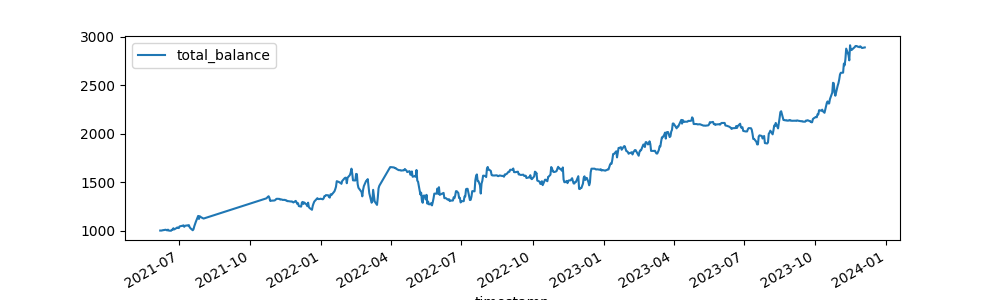

In [8]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

purchased_products = {}
total_products = len(product_ids)

for product_id in product_ids:
    purchased_products[product_id] = 0

money = 1000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 10
max_buy_amount = 100
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []


def get_total_balance():
    total_balance = money

    for product_product_id in product_ids:
        df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == product_product_id)]

        if len(df_final_product_period) > 0:
            total_balance += purchased_products[product_product_id] * df_final_product_period.close.values[-1] * p_keep

    return total_balance


def floor_value(x: float, precision: int):
    return np.true_divide(np.floor(x * 10**precision), 10**precision)


def buy_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        # buy_amount = floor_value(money / total_products / 10, 2)
        buy_amount = floor_value(money / len(products[product_data["product_type"]]) / 10, 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_products = buy_amount / product_data["close"] * p_keep
            purchased_products[product_id] += buy_products
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "products": buy_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


def sell_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        sell_products = floor_value(purchased_products[product_id], 8)
        sell_amount = sell_products * product_data["close"] * p_keep

        if sell_amount > 0:
            purchased_products[product_id] -= sell_products
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "products": sell_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


for index, row in df_final.iterrows():
    if row.product_type == "crypto" and row.fear_greed_index >= 60:
        buy_product(row.product_id)
    elif row.product_type == "stock" and (
        (row.product_id in ["GBTC", "TQQQ"] and (row.RSI_14 >= row.fear_greed_index))
        or (row.product_id == "SQQQ" and (row.RSI_14 >= (100 - row.fear_greed_index)))
    ):
        buy_product(row.product_id)
    else:
        sell_product(row.product_id)

money += sum(
    [
        (purchased_products[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money) / start_money * 100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({"product_id": product_id, "side": side, "total_orders": len(df_orders_product_side)})

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))

In [6]:
# display(df_orders.loc[df_orders.side == "buy"].describe())
# display(df_orders.loc[df_orders.side == "sell"].describe())

In [7]:
# df_final.loc[df_final.product_id == "VGT"][:100][["product_type", "close", "fear_greed_index", "fear_greed_index_max_14", "RSI_14"]]